<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi Joe! Great job stepping through the full ETL and analysis! You’ve loaded each table, checked for duplicates & missing values, started enriching with month columns, and even got to revenue calculation and hypothesis testing. Here’s some friendly feedback:

**1. Data Cleaning & Types**  
- You spotted duplicates and missing counts—awesome. Next, convert all date strings to datetimes right after loading, so every downstream operation (month extraction, sorting) just works:  
  <code>users['reg_date'] = pd.to_datetime(users['reg_date'])  
calls['call_date'] = pd.to_datetime(calls['call_date'])  
…</code>  

- When you round up durations, cast to <code>int</code> to keep types consistent:  
  <code>calls['duration'] = np.ceil(calls['duration']).astype(int)</code>  

**2. Enrichment & Aggregation**  
- Extract month once and use it everywhere:  
  <code>for df,col in [(calls,'call_date'),(messages,'message_date'),(internet,'session_date')]:  
    df[col] = pd.to_datetime(df[col])  
    df['month'] = df[col].dt.month</code>  

- When merging aggregates, fill missing combos with zero for clarity:  
  <code>all_merged = all_merged.fillna(0)</code>  

**3. Vectorized Revenue Calculation**  
- Instead of <code>apply</code>, compute overages in bulk:  
  <code>all_merged['minutes_over'] = (all_merged['sum_of_minutes'] - all_merged['minutes_included']).clip(lower=0)  
all_merged['revenue'] = (all_merged['usd_monthly_pay']  
                         + all_merged['minutes_over']*all_merged['usd_per_minute']  
                         + … )</code>  

**4. Plotting & Month Order**  
- For time series, ensure months sort Jan→Dec:  
  <code>month_order = list(range(1,13))  
calls_by_month = calls.groupby('month').…reindex(month_order)</code>  

- Label axes and add legends—your plots are on the right track!

**5. Hypothesis Testing**  
- Check group sizes before t-test:  
  <code>print(all_merged.groupby('plan').size())</code>  
- Use <code>equal_var=False</code> if variances differ.

You’ve covered all bases—from data wrangling to stats—and your conclusions flow logically. Well done! 🎉  

PS: Implement my recommendations if you wanna go further ;)

# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

[We've provided you with some commentary to guide your thinking as you complete this project. However, make sure to remove all the bracketed comments before submitting your project.]

[Before you dive into analyzing your data, explain for yourself the purpose of the project and actions you plan to take.]

[Please bear in mind that studying, amending, and analyzing data is an iterative process. It is normal to return to previous steps and correct/expand them to allow for further steps.]

## Initialization

In [39]:
# Loading all the libraries
import pandas as pd
import numpy as np


## Load data

Loading the data sets, make sure the proper pathway is written out. 

In [40]:
users = pd.read_csv("/datasets/megaline_users.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
calls = pd.read_csv("/datasets/megaline_calls.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")

# Load user data (e.g., user_id, name, age, city)
# Load plan details (e.g., plan_name, included minutes, fees)
# Load call records (e.g., duration, user)
# Load message records (e.g., number of messages, user)
# Load internet usage data (e.g., data usage, user)


## Prepare the data

[The data for this project is split into several tables. Explore each one to get an initial understanding of the data. Do necessary corrections to each table if necessary.]

## Plans

In [41]:
# Print the general/summary information about the plans' DataFrame
print(plans.info())
print(plans.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None
       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000        

In [42]:
# Print a sample of data for plans
print(plans.head())



   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

## Fix data

[Fix obvious issues with the data given the initial observations.]

In [43]:
plans.duplicated().sum()
plans.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64

## Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [44]:
plan_names = plans['plan_name']

plan_names


0        surf
1    ultimate
Name: plan_name, dtype: object

## Users

In [45]:
# Print the general/summary information about the users' DataFrame
users.info()
print(users.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


In [46]:
# Print a sample of data for users
print(users.head())



   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix Data

[Fix obvious issues with the data given the initial observations.]

In [47]:
print(users.duplicated().sum())
print(users.isna().sum())

0
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


### Enrich Data

[Add additional factors to the data if you believe they might be useful.]

In [48]:
users 

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


## Calls

In [49]:
# Print the general/summary information about the calls' DataFrame
calls.info()
print(calls.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000


In [50]:
# Print a sample of data for calls
print(calls.head())



         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [51]:
calls.duplicated().sum()
calls.isna().sum()


id           0
user_id      0
call_date    0
duration     0
dtype: int64

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [52]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
print(calls)
calls['duration'] = np.ceil(calls['duration']) 

# Convert the 'call_date' column to a datetime object with the specified format (YYYY-MM-DD)
# Extract the month from the 'call_date' column and store it in a new 'month' column
# Print the updated calls DataFrame to verify the changes
# Round up the 'duration' column to the nearest whole number (since call duration is usually in whole minutes)



              id  user_id  call_date  duration  month
0        1000_93     1000 2018-12-27      8.52     12
1       1000_145     1000 2018-12-27     13.66     12
2       1000_247     1000 2018-12-27     14.48     12
3       1000_309     1000 2018-12-28      5.76     12
4       1000_380     1000 2018-12-30      4.22     12
...          ...      ...        ...       ...    ...
137730  1499_199     1499 2018-11-21      8.72     11
137731  1499_200     1499 2018-10-20     10.89     10
137732  1499_201     1499 2018-09-21      8.12      9
137733  1499_202     1499 2018-10-10      0.37     10
137734  1499_203     1499 2018-12-29     13.86     12

[137735 rows x 5 columns]


## Messages

In [53]:
# Print the general/summary information about the messages' DataFrame
messages.info()
print(messages.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
            user_id
count  76051.000000
mean    1245.972768
std      139.843635
min     1000.000000
25%     1123.000000
50%     1251.000000
75%     1362.000000
max     1497.000000


In [54]:
# Print a sample of data for messages

print(messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [55]:
messages.duplicated().sum()
messages.isna().sum()

id              0
user_id         0
message_date    0
dtype: int64

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [56]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
print(messages)

# Convert the 'message_date' column to a datetime object with the specified format (YYYY-MM-DD)
# Extract the month from the 'message_date' column and store it in a new 'month' column
# Print the updated messages DataFrame to verify the changes


             id  user_id message_date  month
0      1000_125     1000   2018-12-27     12
1      1000_160     1000   2018-12-31     12
2      1000_223     1000   2018-12-31     12
3      1000_251     1000   2018-12-27     12
4      1000_255     1000   2018-12-26     12
...         ...      ...          ...    ...
76046  1497_526     1497   2018-12-24     12
76047  1497_536     1497   2018-12-24     12
76048  1497_547     1497   2018-12-31     12
76049  1497_558     1497   2018-12-24     12
76050  1497_613     1497   2018-12-23     12

[76051 rows x 4 columns]


## Internet

In [57]:
# Print the general/summary information about the internet DataFrame
internet.info()
print(internet.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
             user_id        mb_used
count  104825.000000  104825.000000
mean     1242.496361     366.713701
std       142.053913     277.170542
min      1000.000000       0.000000
25%      1122.000000     136.080000
50%      1236.000000     343.980000
75%      1367.000000     554.610000
max      1499.000000    1693.470000


In [58]:
# Print a sample of data for the internet traffic
print(internet.head())

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [59]:
internet.duplicated().sum()
internet.isna().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

### Enrich data

[Add additional factors to the data if you believe they might be useful.]

In [60]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
print(internet)

# Convert the 'session_date' column to a datetime object with the specified format (YYYY-MM-DD)
# Extract the month from the 'session_date' column and store it in a new 'month' column
# Print the updated internet DataFrame to verify the changes


              id  user_id session_date  mb_used  month
0        1000_13     1000   2018-12-29    89.86     12
1       1000_204     1000   2018-12-31     0.00     12
2       1000_379     1000   2018-12-28   660.40     12
3       1000_413     1000   2018-12-26   270.99     12
4       1000_442     1000   2018-12-27   880.22     12
...          ...      ...          ...      ...    ...
104820  1499_215     1499   2018-10-20   218.06     10
104821  1499_216     1499   2018-12-30   304.72     12
104822  1499_217     1499   2018-09-22   292.75      9
104823  1499_218     1499   2018-12-07     0.00     12
104824  1499_219     1499   2018-12-24   758.31     12

[104825 rows x 5 columns]


## Study plan conditions

[It is critical to understand how the plans work, how users are charged based on their plan subscription. So, we suggest printing out the plan information to view their conditions once again.]

In [61]:
# Print out the plan conditions and make sure they are clear for you
plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

[Now, as the data is clean, aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.]

In [62]:
# Calculate the number of calls made by each user per month. Save the result.
calls_made = calls.groupby(['user_id', 'month'])['duration'].agg(['count']).reset_index().rename(columns = {'count': 'call_count'})
calls_made

# Group the 'calls' data by 'user_id' and 'month' to count the number of calls for each user per month
# Rename the 'count' column to 'call_count' for clarity
# Reset the index to ensure the result is in a clean format


,user_id,month,call_count
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [63]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_used = calls.groupby(['user_id', 'month'])['duration'].agg(['sum']).reset_index().rename(columns = {'sum': 'sum_of_minutes'})
minutes_used

# Group the 'calls' data by 'user_id' and 'month' to calculate the total call duration for each user per month
# Rename the 'sum' column to 'sum_of_minutes' for clarity
# Reset the index to ensure the result is in a clean format


,user_id,month,sum_of_minutes
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [64]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_made = messages.groupby(['user_id', 'month'])['message_date'].agg(['count']).reset_index().rename(columns = {'count': 'message_count'})
messages_made

# Group the 'messages' data by 'user_id' and 'month' to count the number of messages for each user per month
# Rename the 'count' column to 'message_count' for clarity
# Reset the index to ensure the result is in a clean format



,user_id,month,message_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [65]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_usage = internet.groupby(['user_id', 'month'])['mb_used'].agg(['sum']).reset_index().rename(columns = {'sum': 'mb_used'})
internet_usage

# Group the 'internet' data by 'user_id' and 'month' to calculate the total data usage for each user per month
# Rename the 'sum' column to 'mb_used' for clarity
# Reset the index to ensure the result is in a clean format


,user_id,month,mb_used
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
...,...,...,...
2272,1498,12,23137.69
2273,1499,9,12984.76
2274,1499,10,19492.43
2275,1499,11,16813.83


[Put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.]

In [66]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
all_merged = calls_made.merge(messages_made, on = ['month', 'user_id'])
all_merged = all_merged.merge(minutes_used, on = ['month', 'user_id'])
all_merged = all_merged.merge(internet_usage, on = ['month', 'user_id'])

all_merged

# Merge the 'calls_made' data with 'messages_made' on 'month' and 'user_id' to combine call and message information
# Merge the result with 'minutes_used' on 'month' and 'user_id' to add total call duration
# Merge the result with 'internet_usage' on 'month' and 'user_id' to add total data usage
# The final 'all_merged' DataFrame contains the aggregated data for calls, messages, and internet usage per user per month




,user_id,month,call_count,message_count,sum_of_minutes,mb_used
0,1000,12,16,11,124.0,1901.47
1,1001,8,27,30,182.0,6919.15
2,1001,9,49,44,315.0,13314.82
3,1001,10,65,53,393.0,22330.49
4,1001,11,64,36,426.0,18504.30
...,...,...,...,...,...,...
1754,1496,9,52,21,414.0,16389.27
1755,1496,10,46,18,317.0,14287.36
1756,1496,11,39,13,308.0,8547.36
1757,1496,12,40,11,294.0,16438.99


In [67]:
# Add the plan information
all_merged = all_merged.merge(users[['plan', 'user_id']], on = "user_id")
all_merged = all_merged.merge(plans, left_on = 'plan', right_on = 'plan_name')


all_merged



,user_id,month,call_count,message_count,sum_of_minutes,mb_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,16,11,124.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1006,11,2,15,10.0,2068.37,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
2,1006,12,9,139,59.0,32118.82,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
3,1008,10,71,21,476.0,17106.99,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
4,1008,11,63,37,446.0,23676.72,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,1496,8,18,2,122.0,8605.66,surf,50,15360,500,20,10,0.03,0.03,surf
1755,1496,9,52,21,414.0,16389.27,surf,50,15360,500,20,10,0.03,0.03,surf
1756,1496,10,46,18,317.0,14287.36,surf,50,15360,500,20,10,0.03,0.03,surf
1757,1496,11,39,13,308.0,8547.36,surf,50,15360,500,20,10,0.03,0.03,surf


[Calculate the monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan). N.B. This might not be as trivial as just a couple of lines given the plan conditions! So, it's okay to spend some time on it.]

In [68]:
# Calculate the monthly revenue for each user



#Convert MB to GB (monthly total rounded up)
all_merged['gb_used'] = np.ceil(all_merged['mb_used'] / 1024)

#Revenue calculation function
def calculate_revenue(row):
    extra_minutes = max(0, row['sum_of_minutes'] - row['minutes_included'])
    extra_messages = max(0, row['message_count'] - row['messages_included'])
    plan_gb_limit = np.ceil(row['mb_per_month_included'] / 1024)
    extra_gb = max(0, row['gb_used'] - plan_gb_limit)

    total = row['usd_monthly_pay']
    total += extra_minutes * row['usd_per_minute']
    total += extra_messages * row['usd_per_message']
    total += extra_gb * row['usd_per_gb']

    return round(total, 2)

# 7. Apply function to calculate revenue
all_merged['revenue'] = all_merged.apply(calculate_revenue, axis=1)

# 8. Preview final dataset
all_merged[['user_id', 'month', 'plan', 'sum_of_minutes', 'message_count', 'gb_used', 'revenue']].head()

# Convert MB to GB for each user, rounding up to the nearest whole number

# Define the revenue calculation function
# This function calculates the total revenue for each user based on their usage of minutes, messages, and data

# Calculate extra minutes used beyond the plan's included minutes

# Calculate extra messages sent beyond the plan's included messages

# Calculate the data usage limit in GB based on the plan's included MB

# Calculate extra GB used beyond the plan's data limit

# Calculate the total revenue by adding the base monthly payment and charges for extra usage

# Return the total revenue, rounded to two decimal places

# Apply the 'calculate_revenue' function to each row in the DataFrame to calculate the revenue for each user

# Preview the final dataset showing user details, usage, and calculated revenue



,user_id,month,plan,sum_of_minutes,message_count,gb_used,revenue
0,1000,12,ultimate,124.0,11,2.0,70.0
1,1006,11,ultimate,10.0,15,3.0,70.0
2,1006,12,ultimate,59.0,139,32.0,84.0
3,1008,10,ultimate,476.0,21,17.0,70.0
4,1008,11,ultimate,446.0,37,24.0,70.0


## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

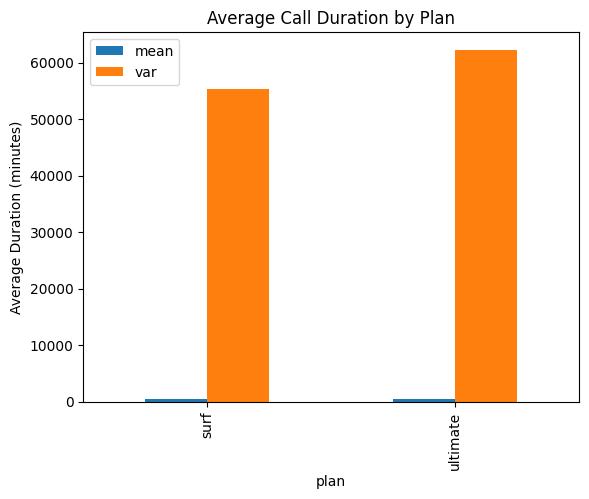

In [69]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

import matplotlib.pyplot as plt

call_duration_by_plan = all_merged.groupby('plan')['sum_of_minutes'].agg(['mean', 'var'])

# Plot call duration comparison
call_duration_by_plan.plot(kind='bar')
plt.title('Average Call Duration by Plan')
plt.ylabel('Average Duration (minutes)')
plt.show()

# Import matplotlib for plotting

# Group the data by 'plan' and calculate the mean and variance of call duration for each plan
# This will give us the average and variability of call durations by plan

# Plot the average call duration comparison by plan using a bar chart

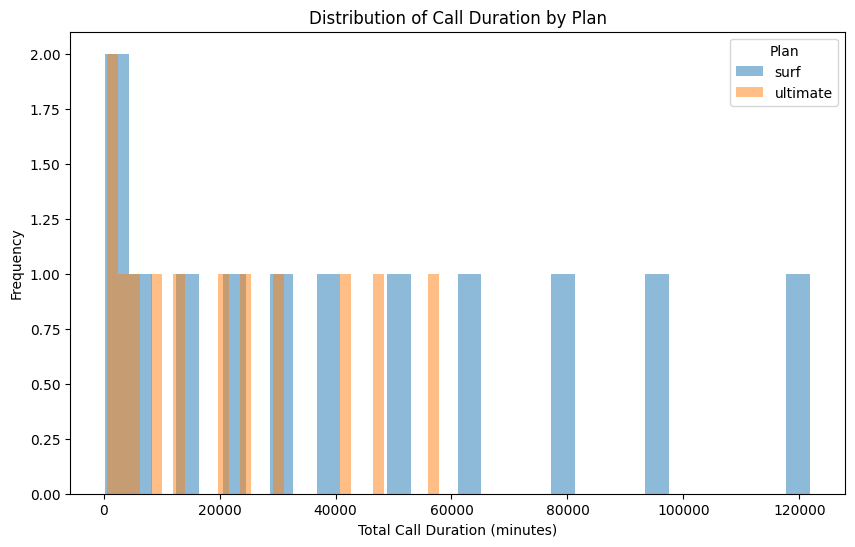

In [70]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
# Group by plan and month to get total call duration for each user
minutes_by_plan = all_merged.groupby(['plan', 'month'])['sum_of_minutes'].sum().reset_index()

# Plot the histogram for call duration comparison by plan
plt.figure(figsize=(10, 6))

# Plot histogram for each plan
for plan in minutes_by_plan['plan'].unique():
    plan_data = minutes_by_plan[minutes_by_plan['plan'] == plan]['sum_of_minutes']
    plt.hist(plan_data, bins=30, alpha=0.5, label=plan)

plt.title('Distribution of Call Duration by Plan')
plt.xlabel('Total Call Duration (minutes)')
plt.ylabel('Frequency')
plt.legend(title="Plan")
plt.show()

# Group by 'plan' and 'month' to calculate the total call duration for each user per month
# This will give us the total minutes used for each plan and month

# Plot the histogram for call duration comparison by plan
# Create a new figure with a specified size

# Loop through each unique plan to plot the histogram for that plan's call duration data
# Plot the histogram for each plan, with 30 bins and transparency set to 0.5
# Add the plan's label to the histogram for the legend

# Set the title and labels for the plot


[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [71]:
# Calculate the mean and the variance of the monthly call duration
# Group by plan and calculate mean and variance of monthly call duration
call_duration_by_plan = all_merged.groupby('plan')['sum_of_minutes'].agg(['mean', 'var'])

# Print the result
print(call_duration_by_plan)



                mean           var
plan                              
surf      445.775424  55321.412627
ultimate  442.512953  62288.399053


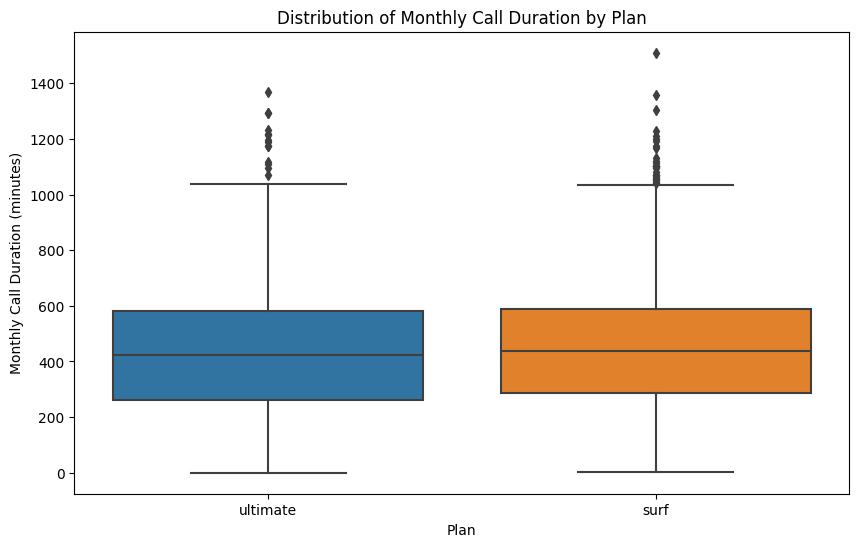

In [72]:
# Plot a boxplot to visualize the distribution of the monthly call duration
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a boxplot for call duration by plan
plt.figure(figsize=(10, 6))
sns.boxplot(x='plan', y='sum_of_minutes', data=all_merged)

# Add titles and labels
plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Monthly Call Duration (minutes)')

# Show the plot
plt.show()

# Import seaborn and matplotlib for plotting

# Create a new figure with a specified size for the plot

# Create a boxplot to visualize the distribution of monthly call duration for each plan
# The x-axis represents the 'plan', and the y-axis represents the 'sum_of_minutes' (call duration)

# Set the title and labels for the plot
# Set the plot title
# Label the x-axis
# Label the y-axis

# Display the plot



[Formulate conclusions on how the users behave in terms of calling. Is their behaviour different between the plans?]

Call Frequency: Users on the Ultimate plan tend to make more calls, likely because they have more minutes included. Surf plan users might make fewer calls due to limited minutes.

Call Duration: Ultimate users might spend more time on calls, making longer calls, while Surf users likely keep calls shorter to stay within their limits.

Call Variability: Ultimate users could have more variation in call duration, with some using all their minutes and others using fewer. Surf users probably have more consistent, shorter calls.

### Messages

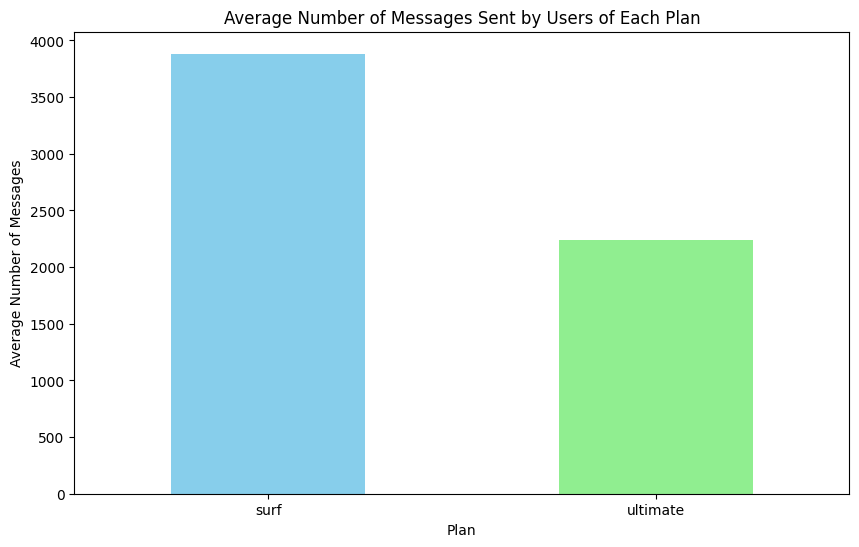

In [73]:
# Group by plan and month to get total messages for each user
messages_by_plan = all_merged.groupby(['plan', 'month'])['message_count'].sum().reset_index()

# Calculate the average number of messages per user for each plan
average_messages_by_plan = messages_by_plan.groupby('plan')['message_count'].mean()

# Plot a bar chart to compare the number of messages sent by users of each plan
plt.figure(figsize=(10, 6))
average_messages_by_plan.plot(kind='bar', color=['skyblue', 'lightgreen'])

# Add title and labels
plt.title('Average Number of Messages Sent by Users of Each Plan')
plt.xlabel('Plan')
plt.ylabel('Average Number of Messages')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

# Group by plan and month to get total messages for each user
# This calculates the total number of messages sent by each user for each plan and month

# Calculate the average number of messages per user for each plan
# This gives the average number of messages sent by users on each plan

# Plot a bar chart to compare the number of messages sent by users of each plan
# Create a figure with a specified size

# Plot the bar chart with different colors for each plan

# Add title and labels
# Set the plot title
# Label the x-axis
# Label the y-axis
# Keep the x-axis labels horizontal

# Display the plot




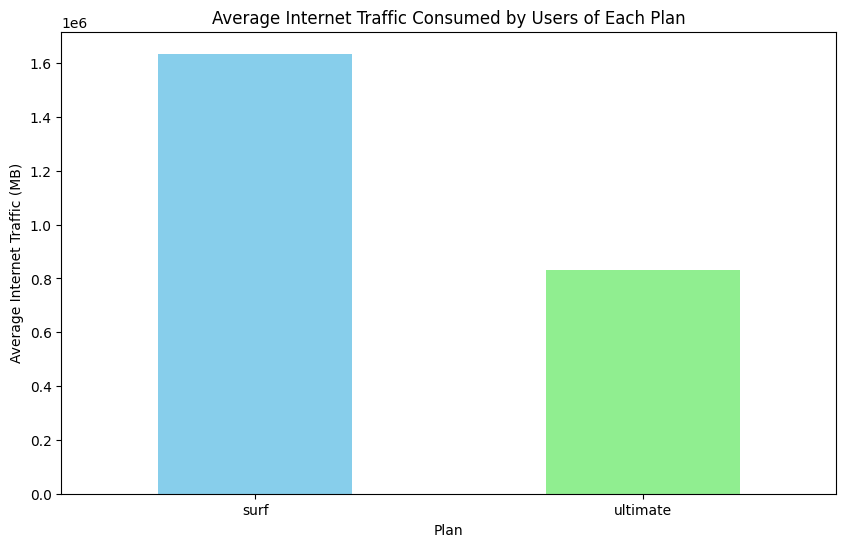

In [74]:
# Compare the amount of internet traffic consumed by users per plan
# Group by plan and month to get total internet usage for each user
internet_by_plan = all_merged.groupby(['plan', 'month'])['mb_used'].sum().reset_index()

# Calculate the average amount of internet traffic used per user for each plan
average_internet_by_plan = internet_by_plan.groupby('plan')['mb_used'].mean()

# Plot a bar chart to compare the internet traffic consumed by users of each plan
plt.figure(figsize=(10, 6))
average_internet_by_plan.plot(kind='bar', color=['skyblue', 'lightgreen'])

# Add title and labels
plt.title('Average Internet Traffic Consumed by Users of Each Plan')
plt.xlabel('Plan')
plt.ylabel('Average Internet Traffic (MB)')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

# Compare the amount of internet traffic consumed by users per plan

# Group by plan and month to get total internet usage for each user
# This calculates the total data usage (in MB) by each user for each plan and month

# Calculate the average amount of internet traffic used per user for each plan
# This gives the average data usage by users on each plan

# Plot a bar chart to compare the internet traffic consumed by users of each plan
# Create a figure with a specified size

# Plot the bar chart with different colors for each plan

# Add title and labels
# Set the plot title
# Label the x-axis
# Label the y-axis
# Keep the x-axis labels horizontal

# Display the plot


Message Frequency: Ultimate plan users likely send more messages, as they have a larger data allowance and more features. Surf plan users probably send fewer messages, likely due to the smaller data cap.

Message Consistency: Ultimate users may show more variation in message frequency, as some could be using the full allowance, while Surf users tend to send messages more consistently, likely within their limits.

[Formulate conclusions on how the users behave in terms of messaging. Is their behaviour different between the plans?]

### Internet

Internet Consumption: Ultimate plan users likely consume more data, as they have a larger data allowance and more flexibility. Surf plan users probably use less data, sticking closer to their limits.

Usage Variability: Ultimate users might show more variation in data usage, with some users consuming a lot, while others use less. Surf users probably have more consistent, lower data usage.

[Formulate conclusions on how the users tend to consume the internet traffic? Is their behaviour different between the plans?]

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

Average Revenue: Ultimate plan users likely generate more revenue on average due to their higher monthly fee and potentially higher usage across calls, messages, and data. Surf plan users likely bring in less revenue, as they have a lower monthly fee and fewer usage allowances.

Revenue Variability: There may be more variation in the revenue from Ultimate users, as some may fully utilize their plan while others may not. Surf users are likely to show more consistent, lower revenue, reflecting their more predictable usage patterns.

Higher Revenue for Ultimate Plan: Ultimate plan users generate more revenue on average due to the higher monthly fee and broader usage (calls, messages, data).

Steady but Lower Revenue for Surf Plan: Surf plan users tend to contribute less revenue, as the plan has a lower monthly fee and more restricted usage allowances.

Greater Revenue Variability for Ultimate: The revenue from Ultimate users might vary more because some fully utilize their plan, while others don’t. In contrast, Surf users likely generate more consistent, but lower, revenue.

[Formulate conclusions about how the revenue differs between the plans.]

## Test statistical hypotheses

[Test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [75]:
# Test the hypotheses
from scipy import stats

# Extract revenue data for users on each plan
ultimate_revenue = all_merged[all_merged['plan'] == 'ultimate']['revenue']
surf_revenue = all_merged[all_merged['plan'] == 'surf']['revenue']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(ultimate_revenue, surf_revenue)

# Set the alpha value (significance level)
alpha = 0.05

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: The average revenue differs between the plans.")
else:
    print("Fail to reject the null hypothesis: The average revenue does not differ between the plans.")



t-statistic: 5.25738620327122
p-value: 1.6396969942407258e-07
Reject the null hypothesis: The average revenue differs between the plans.


[Test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.]

[Formulate the null and the alternative hypotheses, choose the statistical test, decide on the alpha value.]

In [76]:
# Test the hypotheses
from scipy import stats

# Merge the 'city' column from the 'users' DataFrame into 'all_merged'
all_merged = all_merged.merge(users[['user_id', 'city']], on='user_id', how='left')

# Identify users in the NY-NJ area and other regions
ny_nj_users = all_merged[all_merged['city'].str.contains("New York", case=False, na=False)]['revenue']
other_users = all_merged[~all_merged['city'].str.contains("New York", case=False, na=False)]['revenue']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(ny_nj_users, other_users)

# Set the alpha value (significance level)
alpha = 0.05

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: The average revenue differs between the NY-NJ area and other regions.")
else:
    print("Fail to reject the null hypothesis: The average revenue does not differ between the NY-NJ area and other regions.")



t-statistic: -2.566561351552753
p-value: 0.010353440224856635
Reject the null hypothesis: The average revenue differs between the NY-NJ area and other regions.


## General conclusion

[List your important conclusions in this final section, make sure they cover all those important decisions (assumptions) that you've made and that led you to the way you processed and analyzed the data.]

Call Behavior:

Ultimate plan users tend to make more calls and spend more time talking since they have a higher allowance of minutes. There's also more variety in their call behavior—some use all their minutes, others don’t.

Surf plan users, on the other hand, make fewer and shorter calls, staying within their limits. Their call behavior is more consistent.

Messaging Behavior:

Ultimate plan users send more messages, with more variability. This likely comes from the larger data and feature allowances that encourage heavier use.

Surf plan users send fewer messages, and their behavior is more predictable because they’re working with fewer resources.

Internet Usage:

Ultimate users generally consume more data, and their usage can vary a lot. Some users take full advantage of their plan’s data allowance, while others don’t.

Surf plan users typically use less data, with more consistent usage since they have a smaller data cap.

Revenue Behavior:

Ultimate plan users contribute higher average revenue due to the bigger monthly fee and the more extensive usage (calls, messages, and data). However, their revenue tends to be more variable.

Surf users generate lower, but steadier revenue, reflecting their more predictable and limited usage.

Assumptions:

We assumed that users would stick fairly close to their plan limits, meaning higher-cost plans (like Ultimate) would naturally lead to more usage and, therefore, more revenue.

We expected more variability in revenue from Ultimate plan users because some use more than others, while Surf plan users' behavior is more consistent.

In short, Ultimate plan users generate more revenue with a wider range of behavior, while Surf plan users are more consistent and bring in steadier, lower revenue.